## MNIST classification NN

In [223]:
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import random
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch.utils.data import DataLoader
torch.__version__

'2.9.1'

In [224]:
COLOR_NEUTRAL = '#344c63'
COLOR_GOOD = '#62cc7e'
COLOR_BAD = '#cf4d46' 

TRAIN_BATCH_SIZE = 512
TRAIN_EPOCHS = 5
INTERPRETATION_BATCH_SIZE = 10

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset_train = datasets.MNIST("data", download=True, train=True, transform=transform)
dataset_test = datasets.MNIST("data", download=True, train=False, transform=transform)

softmax = nn.Softmax(dim=0)
relu = nn.ReLU()

plt.rcParams['image.cmap'] = 'gray'

In [238]:
loader = DataLoader(dataset_test, batch_size=1, shuffle=True)

def get_random_sample():
    x, y = next(loader._get_iterator())
    return [x.squeeze(0, 1), y.item()]

def get_all_samples(dataset):
    loader = DataLoader(dataset_train, batch_size=len(dataset_train), shuffle=False)
    x, y = next(loader._get_iterator())
    return [x.squeeze(0, 1), y]

x_train, y_train = get_all_samples(dataset_train)
x_test, y_test = get_all_samples(dataset_test)

### Displaying a random image

7


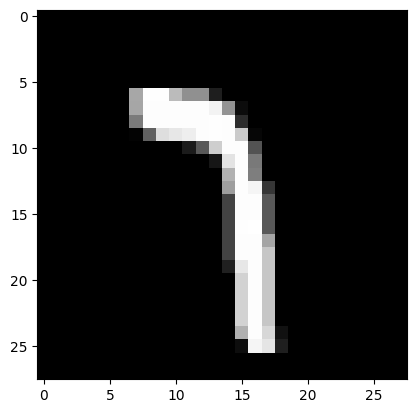

In [242]:
x_sample, y_sample = get_random_sample()

plt.imshow(x_sample)
print(y_sample)

### Classifier architecture


In [243]:
class MNISTClassifier(torch.nn.Module):
    def __init__(self, channels=8, kernel_size=5, stride=1, pool_size=2, pool_stride=2):
        super(MNISTClassifier, self).__init__()
        self.in_channels = 1  # MNIST pictures are grayscale 

        self.pipeline = torch.nn.Sequential(
            nn.Conv2d(1, 8, 5, 1, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
            nn.Conv2d(8, 16, 5, 1, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(3, 3),
            nn.Flatten(),
            nn.Linear(256, 10),
        )

    def forward(self, x):
        return self.pipeline(x)

In [244]:
classifier = MNISTClassifier()

### Predictions on untrained model
Each time a prediction of a sample from test dataset runs, the original picture and probits (softmaxed logits) are displayed

The correct label is displayed with accent color

4


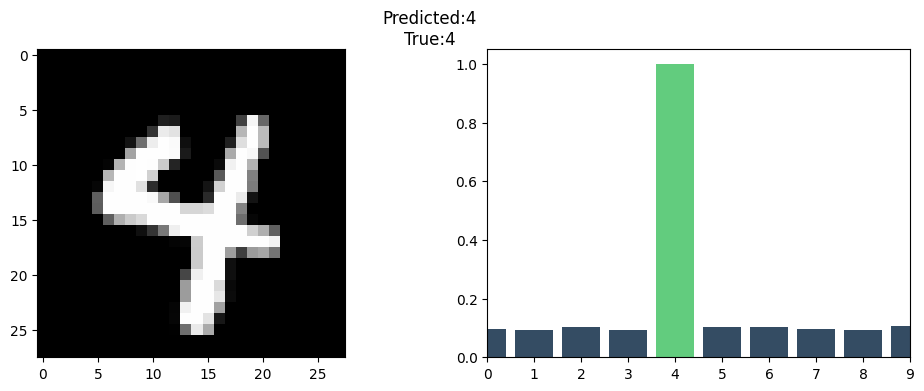

In [245]:
def predict_random_from_train(net: torch.nn.Module, apply_softmax=True): 
    with torch.no_grad():
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        n = random.randint(0, len(x_train))
        ax[0].imshow(x_sample)
        y = (net.forward(x_sample.unsqueeze(0).unsqueeze(0))).squeeze()
        y = softmax(y_sample) if apply_softmax else y_sample 

        ax[1].bar(x=torch.arange(10), height=y_sample, color=COLOR_NEUTRAL)
        ax[1].bar(x=y_train[n], height=1)

        ax[1].set_xlim(0, 9)
        
    return y_sample


def predict_random_from_test(net: torch.nn.Module, apply_softmax=True): 
    with torch.no_grad():
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))

        n = random.randint(0, len(x_test))
        ax[0].imshow(x_sample)
        y = ((net.forward(x_sample.unsqueeze(0).unsqueeze(0))).squeeze())
        y = softmax(y) if apply_softmax else y 

        fig.suptitle(f'Predicted:{y.argmax()}\nTrue:{y_sample}')
        ax[1].bar(x=torch.arange(10), height=y, color=COLOR_NEUTRAL)
        ax[1].bar(x=y_sample, height=1, color=COLOR_GOOD)

        ax[1].set_xlim(0, 9)
        
    return y_sample 

x_sample, y_sample = get_random_sample()

y_sample = predict_random_from_test(classifier, apply_softmax=True)
print(y_sample)

### Training
Currently using Adam optimizer with processing 512 elements per epoch, 20 epochs help the model achieve quite high accuracy

epoch 0, loss 0.26335736794862896
epoch 1, loss 0.09421596152242273
epoch 2, loss 0.07311251238570549
epoch 3, loss 0.05914179250248708
epoch 4, loss 0.04809989231580403


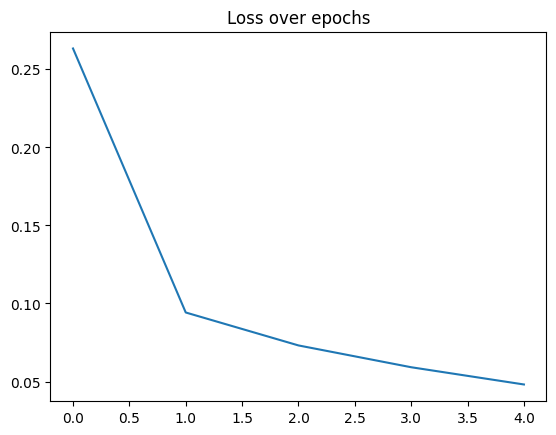

In [246]:
def fit(classifier, epochs=20, verbose=True):
    optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001, weight_decay=0)
    loss = nn.CrossEntropyLoss()

    history = []
    train_loader = DataLoader(dataset_train, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=2)

    for epoch in range(0, epochs):
        epoch_loss = 0

        for x_batch, y_true_batch in train_loader:
            optimizer.zero_grad()
            logits = classifier.forward(x_batch)
            
            loss_val = loss(logits, y_true_batch)
            loss_val.backward()
            
            optimizer.step()
            epoch_loss += loss_val.item()

        epoch_loss /= train_loader.batch_size
        history.append(epoch_loss)

        if verbose:
            print(f'epoch {epoch}, loss {epoch_loss}')
    
    return history

history = fit(classifier, TRAIN_EPOCHS)

plt.title("Loss over epochs")
plt.plot(torch.arange(0, TRAIN_EPOCHS), history)

In [247]:
def calculate_accuracy(classifier, x_test, y_test):
    with torch.no_grad():
        predicted = torch.argmax(classifier.forward(x_test.unsqueeze(1)), dim=1)
        accuracy = ((predicted == y_test).sum() / y_test.shape[0]).item()
    return accuracy
    
calculate_accuracy(classifier, x_test, y_test)

0.9452999830245972

### Getting activation maps 
The Grad-CAM approach uses activation maps of the last Conv2d layer.

To get them, we register a hook, so every forward pass will lead to ```def hook(model, input, output)``` call.

Actually, the data also contains gradients after backward pass, but we will not use it.

In [248]:
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach().squeeze(0)
    return hook

classifier.pipeline[3].register_forward_hook(get_activation('conv2'))

### Building heatmap

The Grad-CAM approach works with derivatives of logits w.r.t. last Conv2d layer neurons. 

Here the last linear layer neurons are used, because their gradients are same to Conv2d layer gradients

Assuming the last layer to have shape (4, 4, 16), we then flatten it to (1, 256), so mean sum of them (used for alpha coefficients) can be retrieved quite easily 

The last operation here is linear combination of 16 activation maps with coefficients got on the previous step

In [249]:
def build_heatmap(net, image: Tensor, c=0):
    y = net.forward(image)
    y_c = y[0][c]
    y_c.backward()

    d_yc_d_linear = classifier.pipeline[-1].weight.grad[c]
    d_yc_d_Map = lambda k: d_yc_d_linear[16 * (k - 1) : 16 * k - 1]
    
    alpha_c = torch.zeros(16)
    heatmap = torch.zeros_like(activation['conv2'][0])
    for k in range(16):
        alpha_c[k] = d_yc_d_Map(k).mean()
        activation_map = activation['conv2'][k]
        heatmap += alpha_c[k].item() * activation_map
        
    return relu(heatmap).detach()

### Interpretation

Here we have a batch of 10 random images, each picture contains original image, heatmap (in negative colormap), Grad-CAM heatmap put on image and prediction data (logits)

It's important to mention that heatmaps are scaled up as originally they have shape (14, 14) which is smaller than the original picture (28, 28). Bicubic interpolation is used here, so the regions heatmap has effect on are displayed more precisely

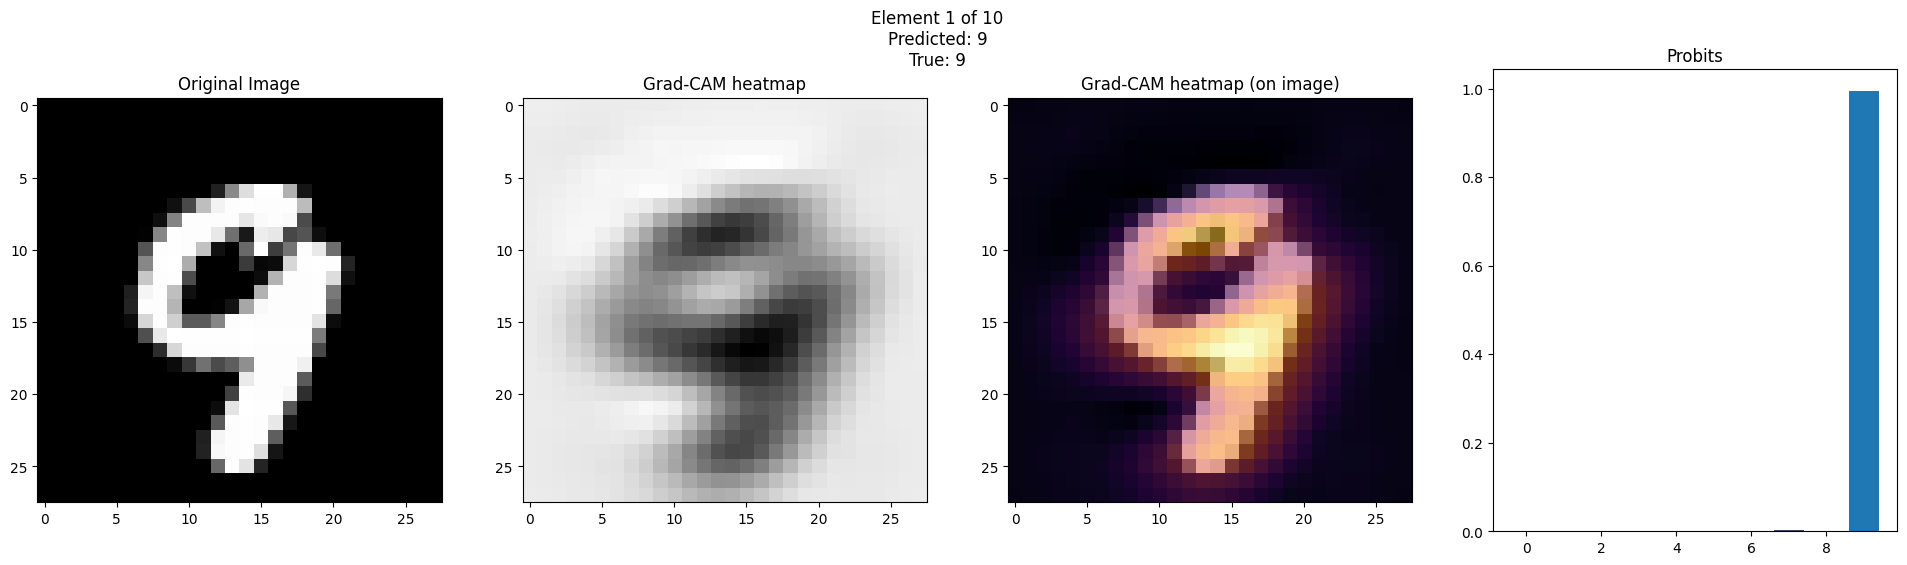

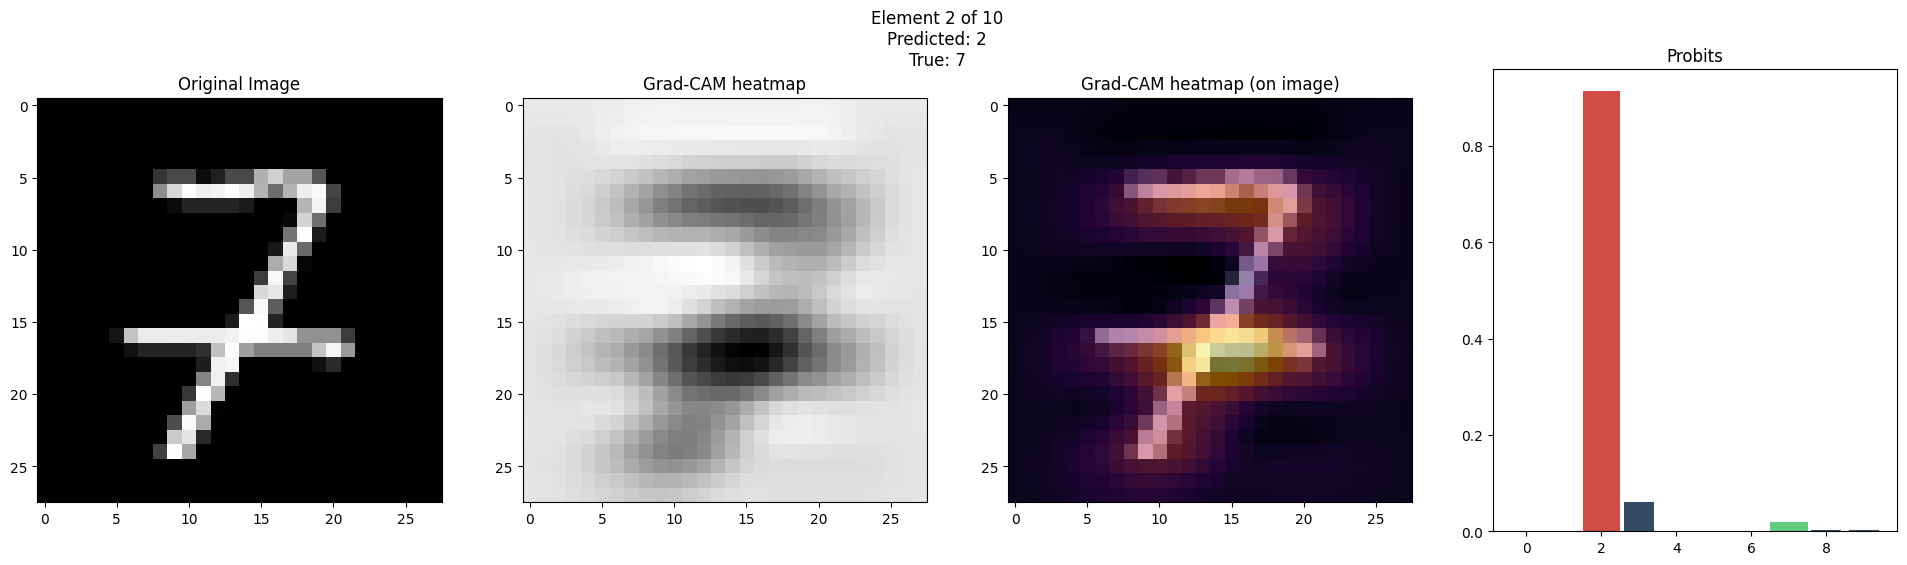

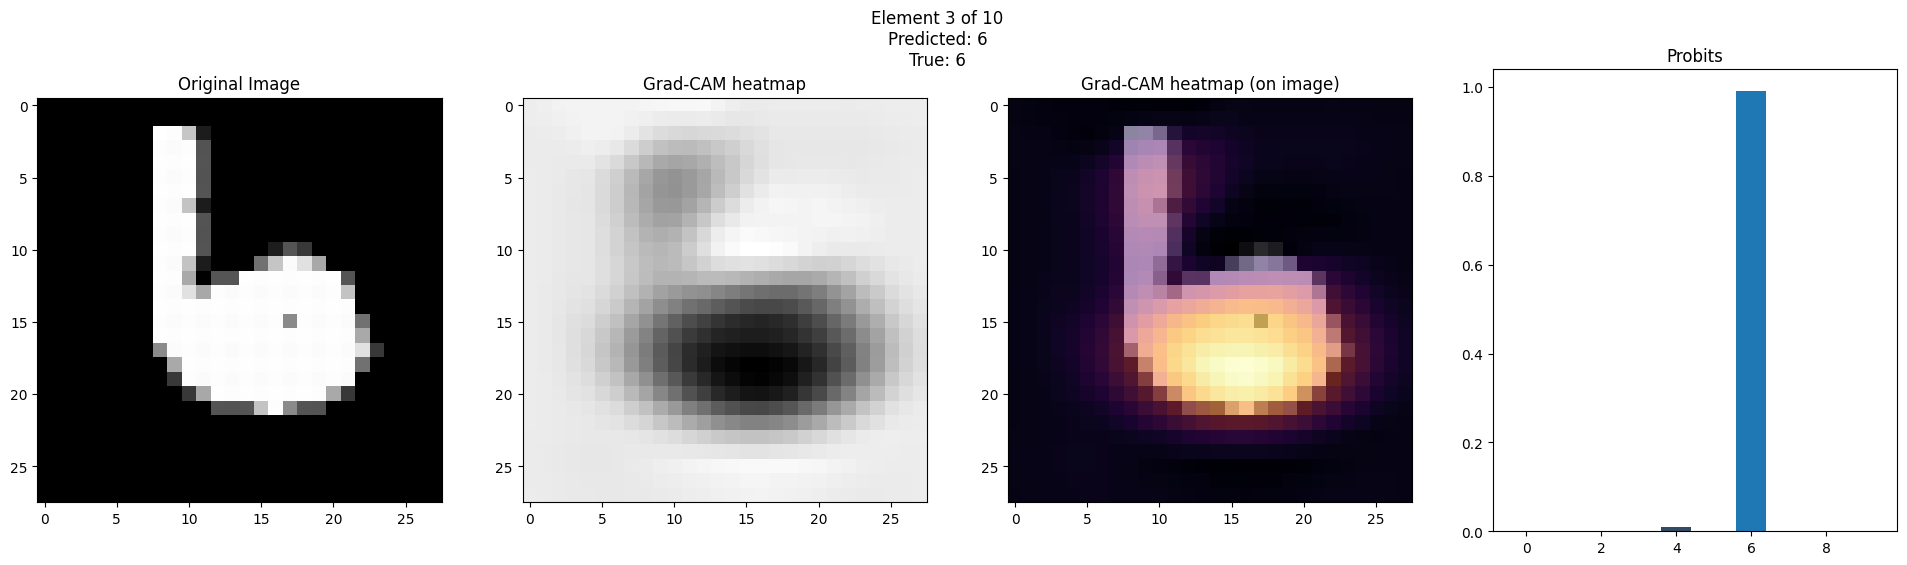

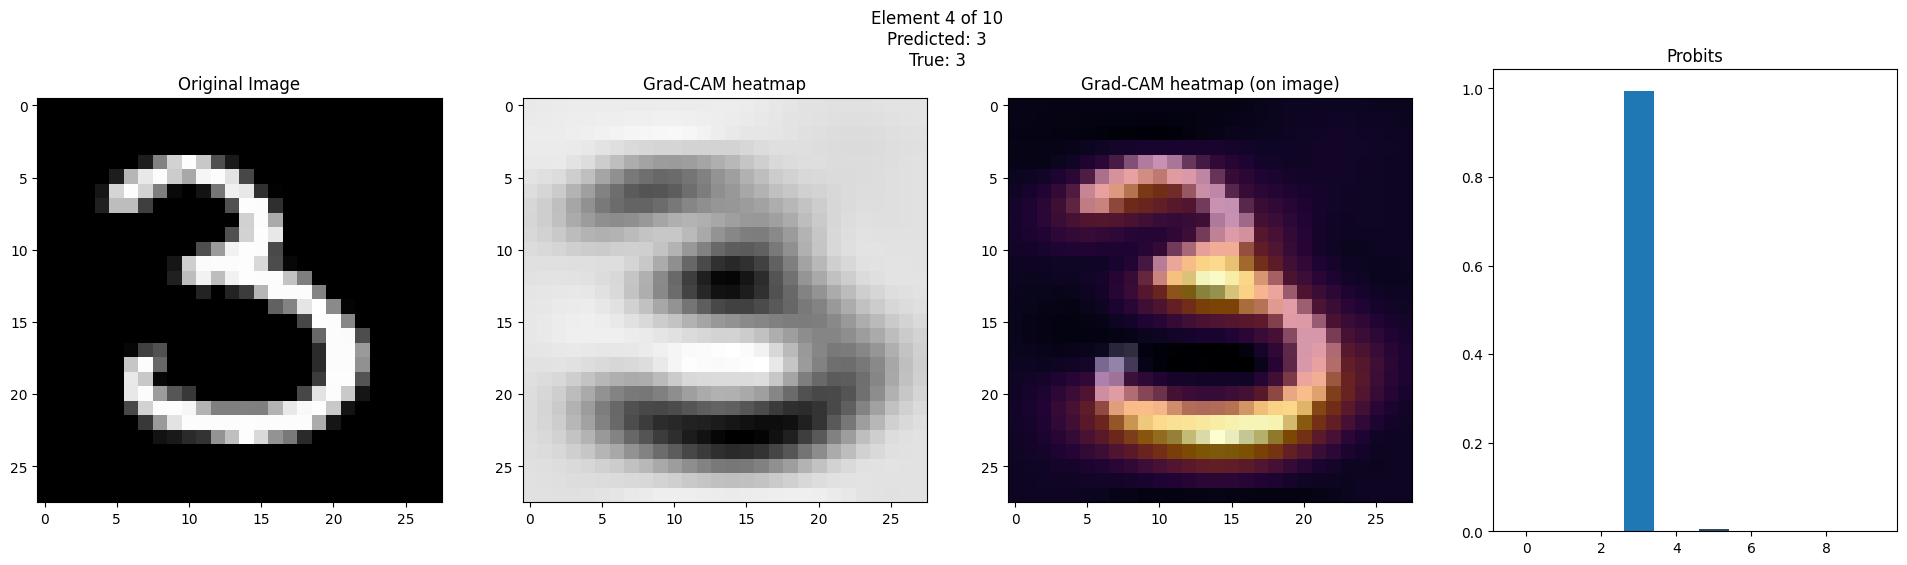

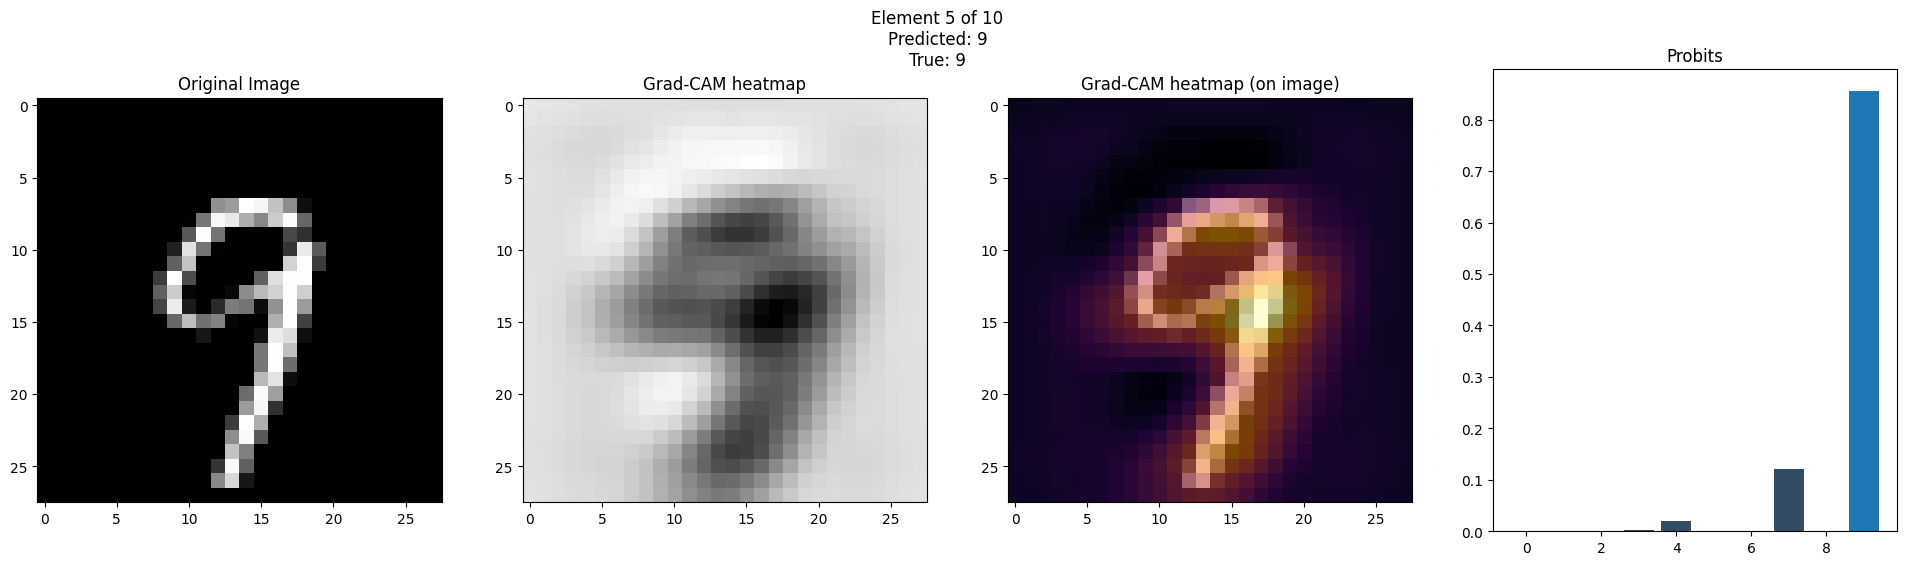

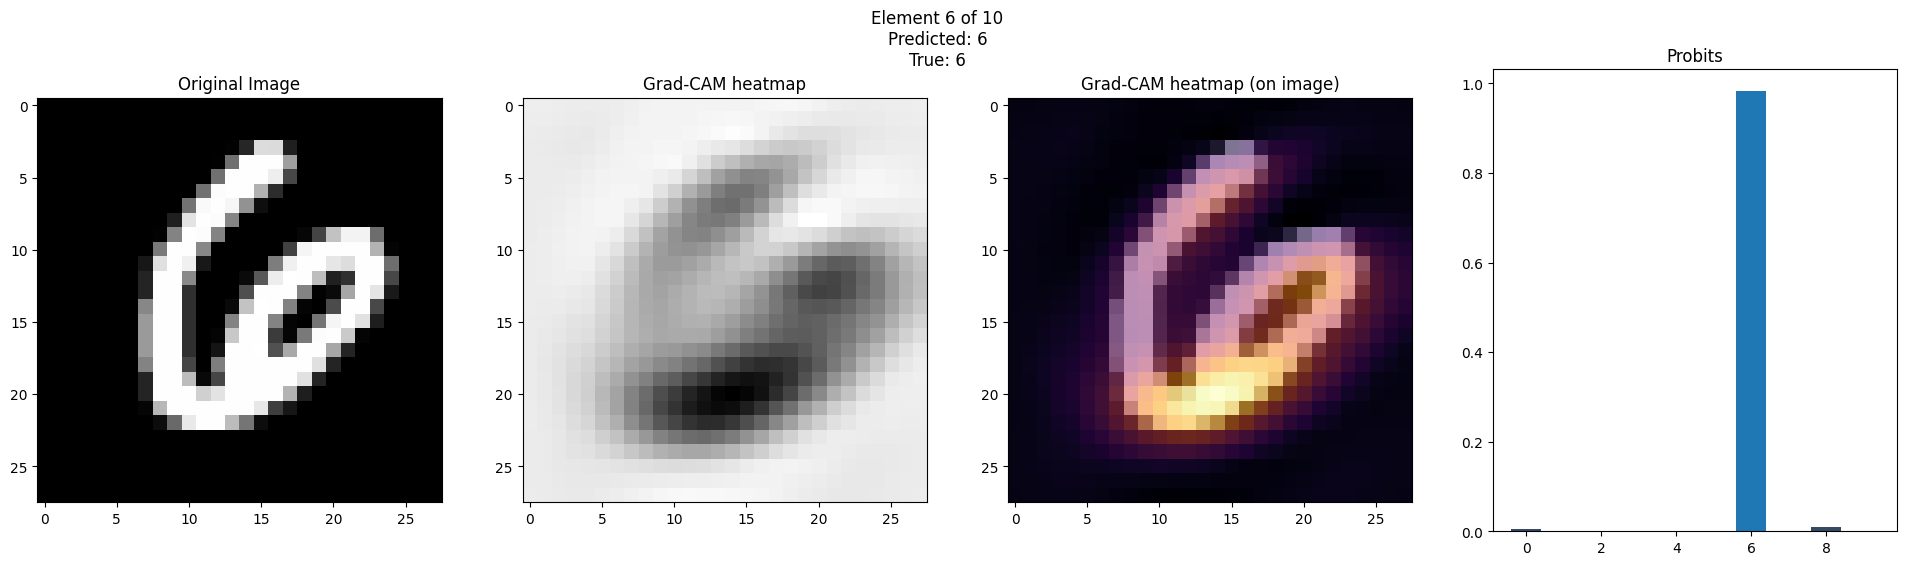

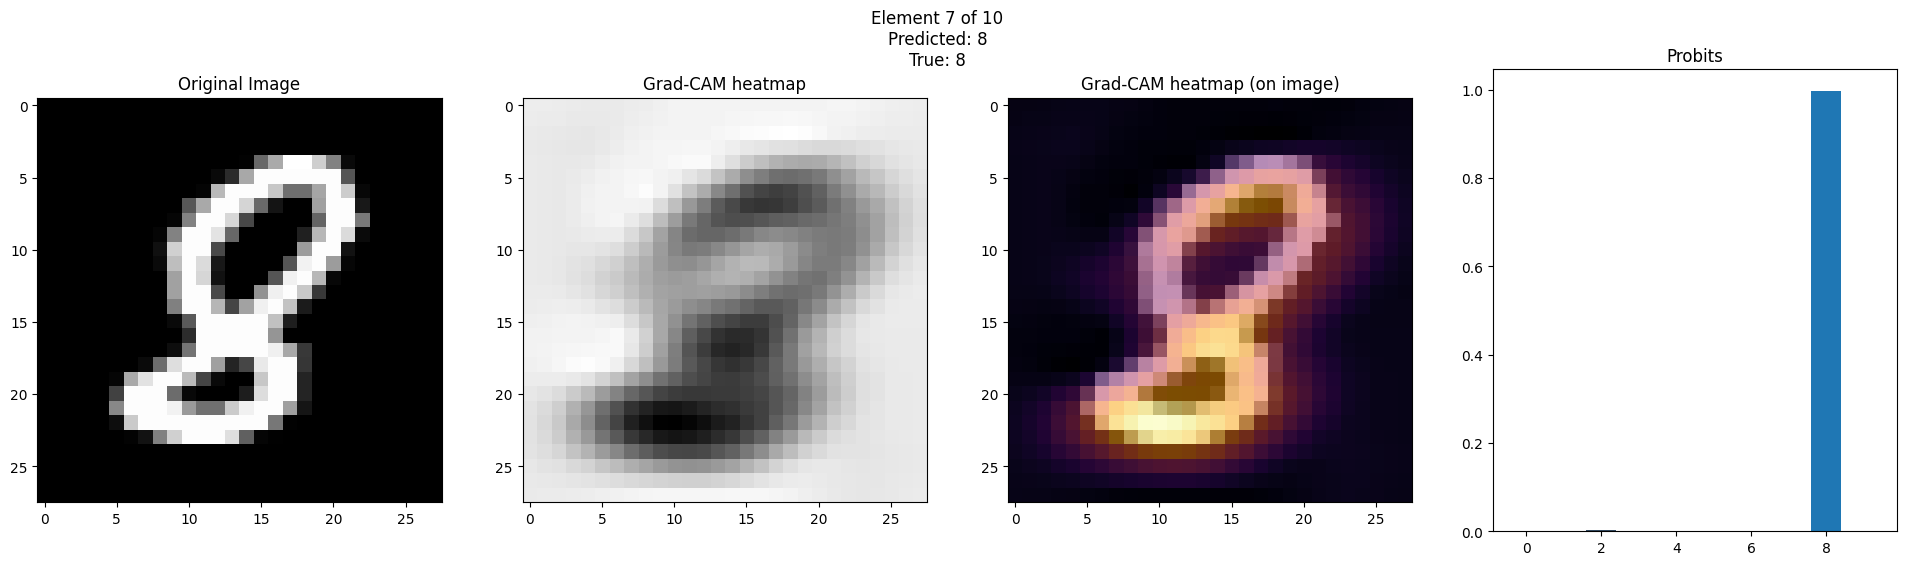

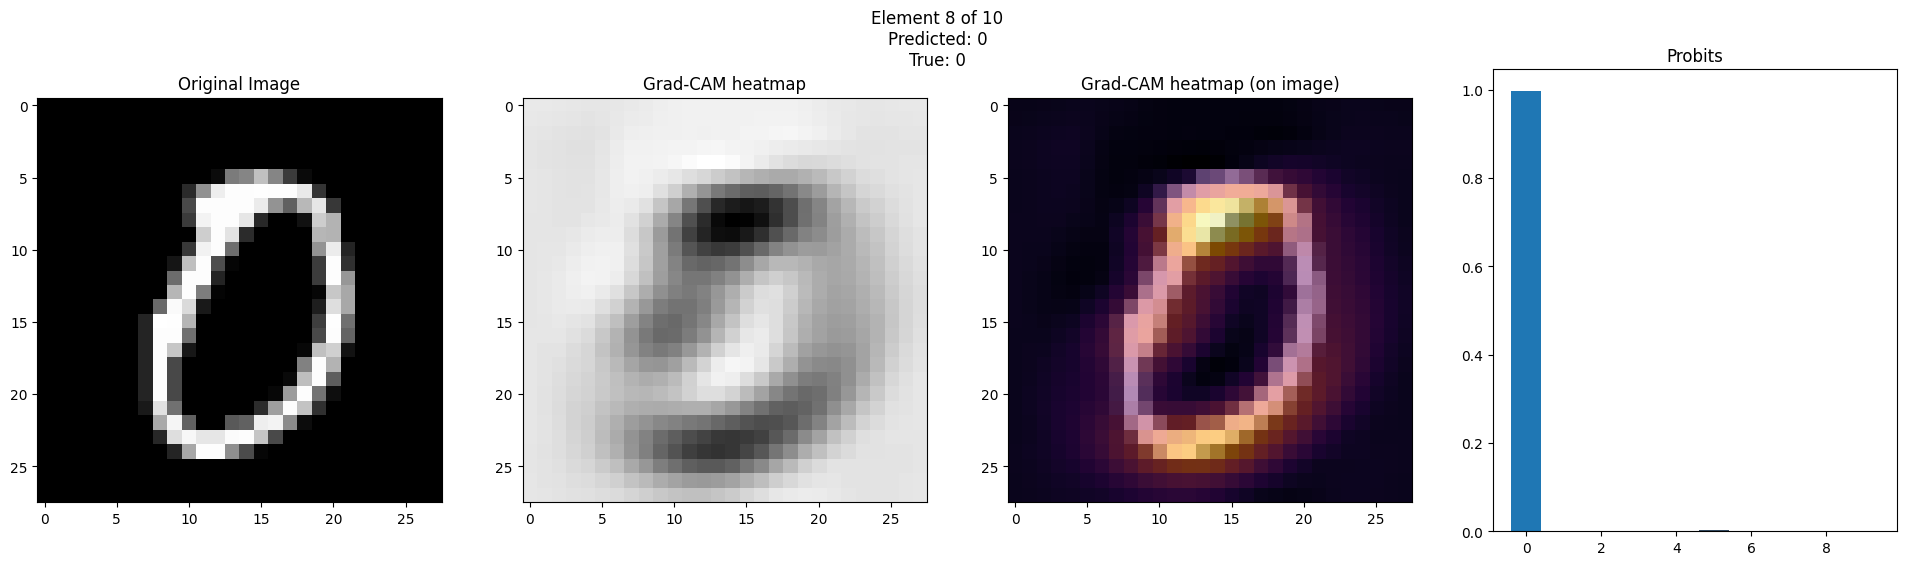

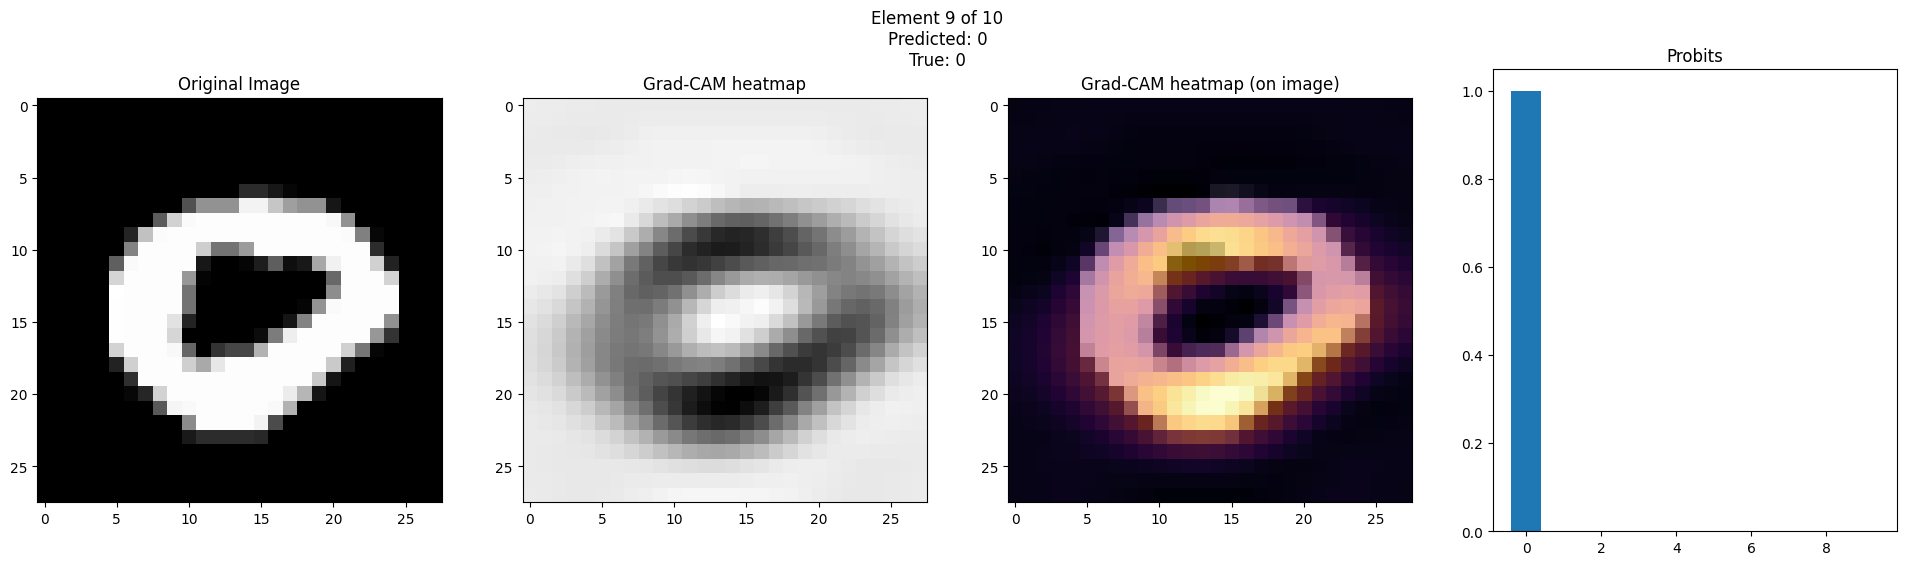

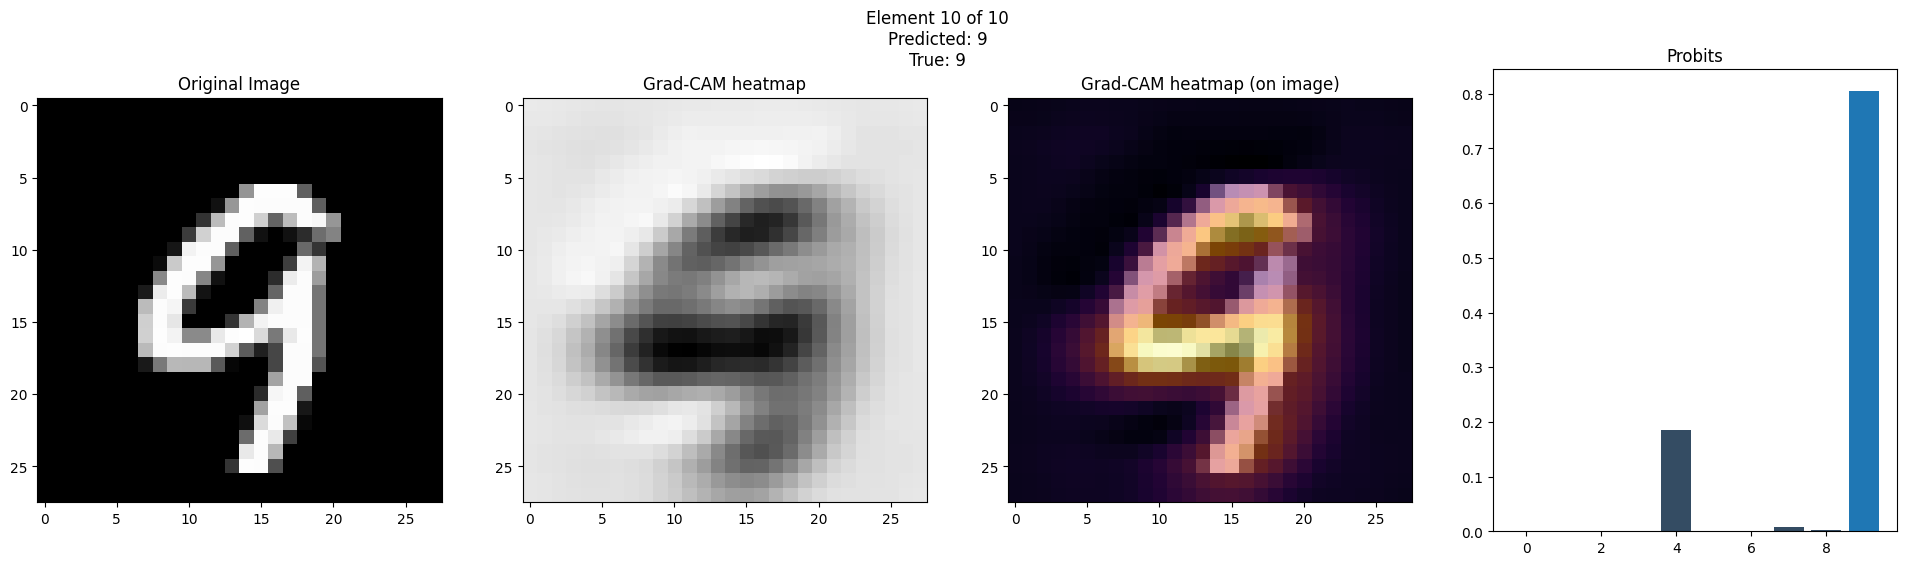

In [381]:
validation_batch = DataLoader(dataset_test, batch_size=INTERPRETATION_BATCH_SIZE, num_workers=2, shuffle=True)

x_batch, y_batch = next(validation_batch._get_iterator())

images = []
heatmaps = []

for n in range(INTERPRETATION_BATCH_SIZE):
    x_sample = x_batch[n].unsqueeze(0)

    y_true_sample = y_batch[n].squeeze(0)
    y_pred_sample_probits = softmax(classifier.forward(x_sample).detach().squeeze())
    y_pred_sample = y_pred_sample_probits.argmax()
    
    heatmap = build_heatmap(classifier, x_sample, c=y_pred_sample)
    x_sample = x_sample.squeeze(0).squeeze(0)
    
    fig, ax = plt.subplots(1, 4, figsize=(24, 6))

    fig.suptitle(f'Element {n + 1} of {INTERPRETATION_BATCH_SIZE}\nPredicted: {y_pred_sample}\nTrue: {y_true_sample}')

    ax[0].set_title("Original Image")
    ax[0].imshow(x_sample)
    ax[1].set_title("Grad-CAM heatmap")
    ax[1].imshow(-F.interpolate(heatmap.unsqueeze(0).unsqueeze(0), scale_factor=2, mode='bicubic')[0][0])
    ax[2].set_title("Grad-CAM heatmap (on image)")
    
    scaled_heatmap = F.interpolate(heatmap.unsqueeze(0).unsqueeze(0), scale_factor=2, mode='bicubic')[0][0]
    
    ax[2].imshow(x_sample)
    ax[2].imshow(scaled_heatmap, alpha=0.5, cmap='inferno')
    ax[3].set_title(f"Probits")
    ax[3].bar(x=torch.arange(0, 10), height=y_pred_sample_probits, color=COLOR_NEUTRAL)
    ax[3].bar(x=y_pred_sample, height=max(y_pred_sample_probits))
    
    if y_pred_sample != y_true_sample:
        ax[3].bar(x=y_pred_sample, height=max(y_pred_sample_probits), width=1, color=COLOR_BAD)
        ax[3].bar(x=y_true_sample, height=y_pred_sample_probits[y_true_sample], width=1, color=COLOR_GOOD)

    images.append(x_sample)
    heatmaps.append(scaled_heatmap)


### Fidelity

Fidelity represents how far we would be from the original predictions if all "less necessary" pixels were thrown out. 

This implementation contains a lot of additinal pretty-print, which can be disabled if ```verbose=True``` isn't specified.

In [382]:
def fidelity(net, image, heatmap, threshold = 5/6, verbose=False):
    acc = 0
    with torch.no_grad():
        masked_image = image.clone()
        threshold_brightness = torch.amax(heatmap) * threshold
        masked_image[heatmap < threshold_brightness] = 0
        f_x = softmax((net.forward(image.unsqueeze(0).unsqueeze(0))).squeeze())
        f_xm = softmax(net.forward(masked_image.unsqueeze(0).unsqueeze(0)).squeeze())

        if (verbose):
            fig, ax = plt.subplots(1, 5, figsize=(20, 6))
            fig.suptitle(f'Fidelity calculation\nPredicted on original image:{f_x.argmax().item()}\nPredicted on mask:{f_xm.argmax().item()}\nThreshold:{threshold}')
            ax[0].imshow(image)
            ax[0].set_title('Original image')
            ax[1].imshow(heatmap)
            ax[1].set_title('Heatmap')
            ax[2].imshow(masked_image)
            ax[2].set_title('Masked image')
            ax[3].bar(torch.arange(0, 10), f_x)
            ax[3].set_title('Original image probits')
            ax[3].set_box_aspect(1)

            ax[4].bar(torch.arange(0, 10), f_xm)
            ax[4].set_title('Masked image probits')
            ax[4].set_box_aspect(1)

        return [f_x.squeeze(0), f_xm.squeeze(0), (f_x - f_xm).mean().item()]

### Calculating fidelity on the batch

Given the batch we've retrieved heatmaps for, we now get fidelity for each element and display mean and dispertion

In [418]:
fidelities = torch.zeros(INTERPRETATION_BATCH_SIZE)
original_probits = []
masked_probits = []

threshold = 3/6
for n in range(INTERPRETATION_BATCH_SIZE):
    x_sample = x_batch[n].squeeze(0, 1, 2)
    o, m, f = fidelity(classifier, x_sample, scaled_heatmap, threshold)
    
    original_probits.append(o)
    masked_probits.append(m)
    fidelities[n] = f

f_mean = fidelities.mean().item()
D = ((fidelities - torch.full(fidelities.shape, f_mean))**2).mean()
print(f'Mean fidelity: {f_mean}')
print(f'D: {D}')

Mean fidelity: 3.827906436271178e-09
D: 5.99845506013895e-17


### Example

Pick a random image, get its masked variant and compare original and masked prediction logits

2.0465051875362406e-08

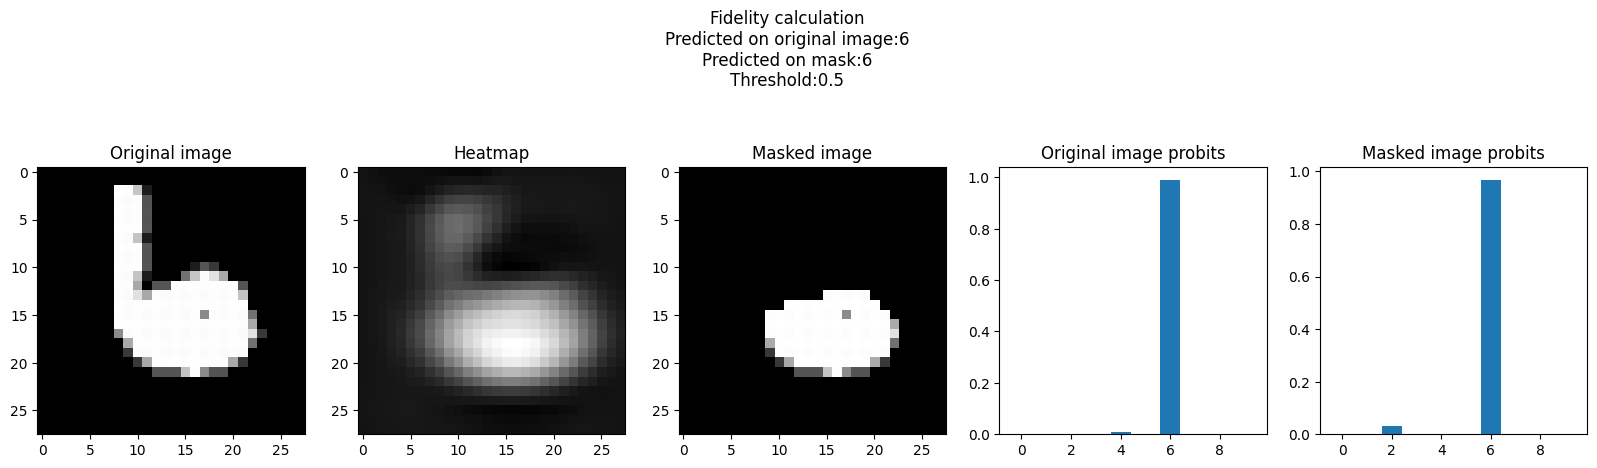

In [434]:
n = random.randint(0, len(images) - 1)
logits_orig, logits_masked, fid = fidelity(classifier, images[n], heatmaps[n], threshold, True)
fid